In [1]:
import itertools
import pickle

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_data(filename):
    ids = []
    data = []
    labels = []
    with open(filename, 'rb') as f:
        while 1:
            try:
                d = pickle.load(f)
                features = []
                for lb in ['PA', 'PB']:
                    if len(d[lb]) == 0:
                        break
                    max_att = d[lb][0]
                    for att in d[lb][1:]:
                        max_att = np.maximum(max_att, att)
                    d[lb] = max_att[16:20, :]
                    features.append(d[lb].flatten())
                if len(d[lb]) == 0:
                    continue
                labels.append(d['label'])
                ids.append(d['ID'])
                data.append(np.concatenate(features))
            except EOFError:
                break
    return ids, data, labels

In [3]:
IDs_train1, X_train1, Y_train1 = get_data('./data/large-atts-gap-validation.pkl')
IDs_train2, X_train2, Y_train2 = get_data('./data/large-atts-gap-test.pkl')
IDs_train = IDs_train1 + IDs_train2
X_train = X_train1 + X_train2
Y_train = Y_train1 + Y_train2
IDs_test, X_test, Y_test = get_data('./data/large-atts-gap-development.pkl')

In [4]:
print(len(X_train), len(X_test))

2453 1998


In [5]:
X_train[0].shape

(128,)

In [6]:
clf = ExtraTreesClassifier(bootstrap=True, criterion='gini', max_features=0.75, min_samples_leaf=1, min_samples_split=18, n_estimators=100)
clf.fit(X_train, Y_train)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.75, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=18,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [7]:
clf.score(X_test, Y_test)

0.8898898898898899

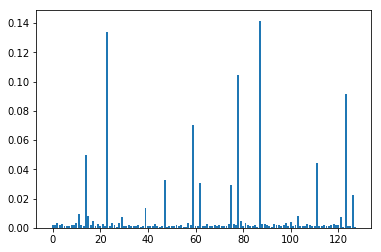

In [8]:
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

In [9]:
column_indices = []
for fttt in ['PA', 'PB']:
    for l in range(16, 20):
        for h in range(16):
            column_indices.append(f'{fttt}L{l}H{h}')
feature_importances = pd.Series(clf.feature_importances_, column_indices).sort_values(ascending=False)
feature_importances.head(20)

PBL17H7     0.141597
PAL17H7     0.133602
PBL16H14    0.104289
PBL19H11    0.091763
PAL19H11    0.070558
PAL16H14    0.049801
PBL18H15    0.044180
PAL18H15    0.032782
PAL19H14    0.030541
PBL16H11    0.029360
PBL19H14    0.022535
PAL18H7     0.013677
PAL16H11    0.009493
PBL18H7     0.008372
PAL16H15    0.007769
PAL17H13    0.007585
PBL19H9     0.007278
PAL17H1     0.004622
PBL16H15    0.004344
PBL18H4     0.004130
dtype: float64

In [10]:
Y_test_ones = np.array([[int(x=='A'), int(x=='B'), int(x=='Neither')] for x in Y_test])

In [11]:
Y_pred = clf.predict_proba(X_test)

In [12]:
log_loss(Y_test_ones, Y_pred)

0.345438816067647

In [13]:
# submission = pd.read_csv('input/sample_submission_stage_1.csv', index_col='ID')
# for _id, pred in zip(IDs_test, Y_pred):
#     submission.loc[_id, 'A'] = pred[0]
#     submission.loc[_id, 'B'] = pred[1]
#     submission.loc[_id, 'NEITHER'] = pred[2]
# submission.to_csv(f'output/TPOT.csv')